# Part1: Time Domain Analysis

## Control robotic vehicle using intelligent techiques of Machine Learning 

Αν γίνει κάτι στο πεδίο του χρόνου, υπαρχει η έκδοση 30_7_2021

In [ ]:
! pip install beautifultable
! pip install tslearn
! pip install minisom
! pip install sktime[all_extras]

In [ ]:
import os
import math
import random
import pathlib

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


import numpy as np
import seaborn as sns
import tensorflow as tf

from skimage.measure import block_reduce
from beautifultable import BeautifulTable


from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import librosa
import librosa.display

from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from minisom import MiniSom

import pandas as pd

from sktime.datatypes._panel._convert import from_nested_to_2d_array, from_2d_array_to_nested

#from sktime.utils.data_processing import from_nested_to_2d_array
#from sktime.utils.data_processing import from_2d_array_to_nested

from sktime.classification.compose import ComposableTimeSeriesForestClassifier


## Dataset preview

Dataset: [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google and released under a CC BY license. These words are either:
<br/><br/> Words:
*   Basic Words: **Yes**, **No**, **Up**, **Down**, **Left**, **Right**, On, Off, **Stop**, **Go**, Zero, **One**, **Two**, **Three**, Four, Five, Six, Seven, Eight, and Nine.
*   Auxiliary Words: Bed, Bird, Cat, Dog, Happy, House, Marvin, Sheila, Tree, and Wow.
*  Environment's noise: doing_the_dishes, dude_miaowing, exercise_bike, pink_noise, running_tap, and white_noise.

Location: `speech_commands_v0` folder in GoogleDrive

<br/> In bold have been marked the words that will be used for training. For proper memory managment the other words have been removed. As a result in `speech_commands_v0.01` are located samples of 11 selected words.


Check [Read Commands](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [ ]:
# Connection with google colab in order to load dataset
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change Direcotry and set dataset_dir as default
os.chdir('/content/drive/my_project/my_project/speech_commands_v0.01')

In [ ]:
!pwd

/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01


In [ ]:
data_dir = os.getcwd()
print(data_dir)

/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01


In [ ]:
## Check basic statistics about the dataset.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print("Commands:", commands)

Commands: ['left' 'right' 'go' 'stop' 'yes' 'no' 'up' 'down' 'one' 'two' 'three'
 'four']


In [ ]:
## Extract the audio files into a list and shuffle it.
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)

Number of total examples: 28462


In [ ]:
## Preview dataset 
table = BeautifulTable()
table.column_headers = ["", "Samples"]
for command in commands:
  table.append_row([command,  len(tf.io.gfile.listdir(data_dir+'/'+str(command)))])

table.append_row(['TOTAL',num_samples])
print(table)

/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


+-------+---------+
|       | Samples |
+-------+---------+
| left  |  2354   |
+-------+---------+
| right |  2373   |
+-------+---------+
|  go   |  2372   |
+-------+---------+
| stop  |  2381   |
+-------+---------+
|  yes  |  2377   |
+-------+---------+
|  no   |  2375   |
+-------+---------+
|  up   |  2379   |
+-------+---------+
| down  |  2359   |
+-------+---------+
|  one  |  2371   |
+-------+---------+
|  two  |  2383   |
+-------+---------+
| three |  2366   |
+-------+---------+
| four  |  2372   |
+-------+---------+
| TOTAL |  28462  |
+-------+---------+


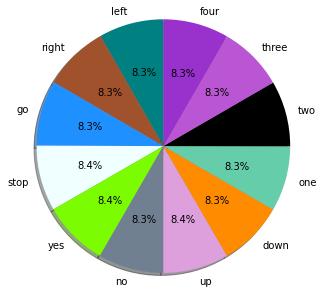

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = commands
sizes = [len(tf.io.gfile.listdir(data_dir+'/'+str(command))) for command in commands]
colors = random.choices(list(mcolors.CSS4_COLORS.values()),k = 12)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True,colors = colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

As we see, dataset is balacned. The samples of each label are almost equal.

### Split Dataset

Now we want to apply time series clustering and testing, without splitting dataset. Then comparing with true labels we can come to the concusion if the clustering was proper. So if the problem is unsupervised, we use full dataset

In [ ]:
# In supervised we will split the dataset, in unsupervised not.
supervised = True

In [ ]:
def split_dataset(dataset, train_size):
  
  #Reminder: Dataset has already been shuffled
  num_samples = len(dataset)
  train_samples= round(train_size * num_samples)

  train_fs = dataset[:train_samples]
  test_fs = dataset[train_samples:]

  return train_fs,test_fs

In [ ]:
# We define (%) of test and val dataset 
test_size = 0.1
val_size = 0.1 
# 10 % means of all dataset (not for train)

# Train - Test split 
train_files, test_files = split_dataset(filenames, 1-test_size)
# Train - Val split 
train_files, val_files = split_dataset(train_files, 1 - val_size/(1-test_size))

In [ ]:
table = BeautifulTable()
table.column_headers = ["", "Samples", "Size(%)"]

table.append_row(['train',len(train_files),(1 - val_size - test_size)*100])
table.append_row(['val',len(val_files),val_size*100])
table.append_row(['test',len(test_files),test_size*100])

print(table)
print("Total Samples:",num_samples)

+-------+---------+---------+
|       | Samples | Size(%) |
+-------+---------+---------+
| train |  22770  |  80.0   |
+-------+---------+---------+
|  val  |  2846   |  10.0   |
+-------+---------+---------+
| test  |  2846   |  10.0   |
+-------+---------+---------+
Total Samples: 28462


/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


In [ ]:
# if not supervised, there is no need for splitting (cancelled simply!)
if not supervised:
 train_files = filenames

In [ ]:
if (len(train_files) == len(filenames)):
  print("Unsupervised Learning")
else:
  print("Supervised Learning")

Supervised Learning


In [ ]:
# In case of supervised:

# We have train files, test files and val files

# In case of unsupervised:

# We have filenames only

## Data preprocessing

In this step we read audio files using `tf.audio.decode_wav` that converts them into numerical tensors.  Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. Note that this function will normalize the values to the range [-1.0, 1.0].

In [ ]:
# Example:
audio_binary = tf.io.read_file("three/8c3c4715_nohash_2.wav")
audio, f = tf.audio.decode_wav(audio_binary)
a = tf.squeeze(audio, axis=-1)
print(a.numpy())


[ 0.00057983  0.00076294  0.00100708 ... -0.00085449 -0.00067139
 -0.00054932]


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)

  '''
  audio = tf.Tensor(
  [[ 0.00057983]
  [ 0.00076294]
  [ 0.00100708]
  ...
  [-0.00085449]
  [-0.00067139]
  [-0.00054932]], shape=(16000, 1), dtype=float32)
  '''
  return tf.squeeze(audio, axis=-1)

  '''
  tf.Tensor(
  [ 0.00057983  0.00076294  0.00100708 ... -0.00085449 -0.00067139
    -0.00054932], shape=(16000,), dtype=float32)

  '''

The label for each WAV file is its parent directory.

In [ ]:
def get_label(file_path):
  #  Reminder:
  ## filepath: "MyDrive/Thesis_George_Giannios/speech_commands_v0.01/three/8c3c4715_nohash_2.wav"
  parts = tf.strings.split(file_path, os.path.sep)
  
  #So parts[-2] returns in this example: "three"
  return parts[-2]

Define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Why we use 
```Dataset.from_tensor_slices()``` :

The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

*   Create a source dataset from your input data.
*   Apply dataset transformations to preprocess the data.
*   Iterate over the dataset and process the elements.

Iteration happens in a **streaming fashion**, so the full dataset does not need to fit into memory

In [ ]:
# Remember: If supervised train files are a part of dataset
#If unsupervised train_files == filenames 
AUTOTUNE = tf.data.AUTOTUNE                                                     # The number of parallel calls is set dynamically based on available CPU

files_ds = tf.data.Dataset.from_tensor_slices(train_files)                      # Convert each sample to "tf.Tensor(b'/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01/three/8c3c4715_nohash_2.wav', shape=(), dtype=string)"
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE) # Applying transformation to  to seperate labels and wav files


'''
waveform_ds:

tf.Tensor([1,2,3,..,16000]),"three"
tf.Tensor([1,2,3,..,16000]),"two"
etc..

'''

'\nwaveform_ds:\n\ntf.Tensor([1,2,3,..,16000]),"three"\ntf.Tensor([1,2,3,..,16000]),"two"\netc..\n\n'

In [ ]:
# Now we want to find unique labels and plot audio's amplitude along time
total_commands = len(commands)
print("Total Commands are", total_commands)

Total Commands are 12


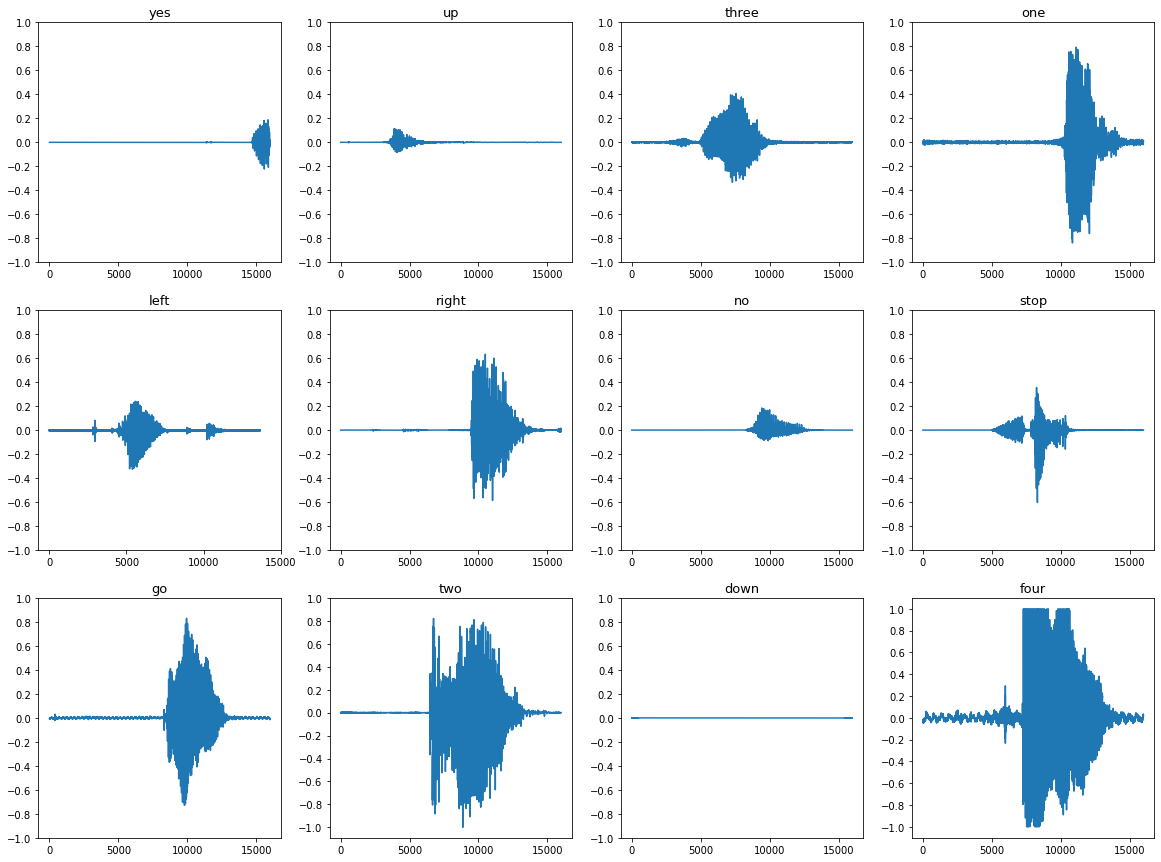

In [ ]:
# Now we want to find unique labels and plot audio's amplitude along time.

## Create grid for plotting 
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

## Initialize seen labels in order to "extract" unique ones
seen_labels = [] 
i = 0;

# We will search for unique labels in 50 out of 26000 samples
search_samples = 100

## Search for unique labels and plot them into grid
for (audio, label) in waveform_ds.take(search_samples):
  
  if label not in seen_labels:

    r = i // cols
    c = i % cols
    ax = axes[r][c]
    
    #Convert tensor to numpy 
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1, 1.2, 0.2))
    ax.set_xticks(np.arange(0, 16000, 5000))
    label = label.numpy().decode('utf-8')
    ax.set_title(label,fontsize = 13)

    if len(seen_labels) == total_commands:
      break;

    seen_labels.append(label)
    i = i + 1 ; 

plt.show()

### Extract Time Domain Features

##### RMS values

In [ ]:
#Apply convolution to get rms values
# https://stackoverflow.com/questions/8245687/numpy-root-mean-squared-rms-smoothing-of-a-signal
def apply_rms(waveform, window_size):
  
  #ex: waveform = tf.Tensor(
  #[0.0000000e+00 3.0517578e-05 3.0517578e-05 ... 6.1035156e-05 6.1035156e-05
  #6.1035156e-05], shape=(16000,), dtype=float32)

  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  
  # ex: equal_length = tf.Tensor(
  # [0.0000000e+00 3.0517578e-05 3.0517578e-05 ... 6.1035156e-05 6.1035156e-05
  # 6.1035156e-05], shape=(16000,), dtype=float32)

  a2 = tf.pow(equal_length,2)
  #[numpy] a2 = np.power(waveform,2) 
  
  window = tf.ones(window_size)/float(window_size)
  #[numpy] window = np.ones(window_size)/float(window_size)
  
  # int(window.shape[0]) = 250
  # a2.shape[0] = 16000

  data   = tf.reshape(a2, [1, 16000, 1], name='data')
  kernel = tf.reshape(window, [window_size, 1, 1], name='kernel')
  

  res =  tf.squeeze(tf.nn.conv1d(data, kernel,stride = window_size,padding='VALID'))
  #[numpy] res =  np.sqrt(np.convolve(a2, window, 'valid'))
  

  # ex: res = tf.Tensor(
  # [5.004015e-04 5.069687e-04 5.129895e-04 ... 7.024032e-06 7.060689e-06
  # 7.082724e-06], shape=(15751,), dtype=float32)
  
  return res

In [ ]:
# Extract the first signal of dataset 
EXAMPLES = 7


waveforms = []
labels = []
rms_signals = []

for waveform, label in waveform_ds.take(EXAMPLES):
  waveforms.append(waveform)
  
  label = label.numpy().decode('utf-8')
  labels.append(label)
  
  rms_signal = apply_rms(waveform,80)
  rms_signals.append(rms_signal)

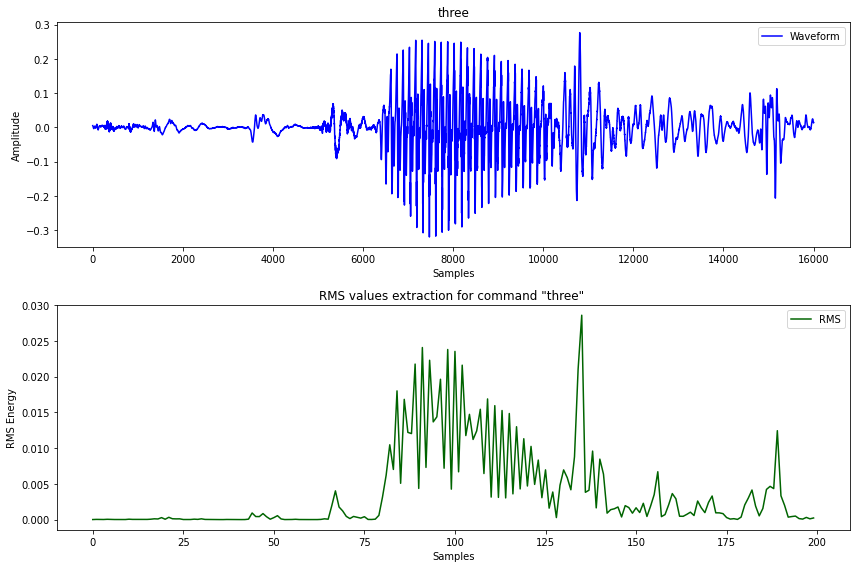

In [ ]:
#Print signal 
fig, axs = plt.subplots(2,figsize=(12,8))
#fig.suptitle("Εxtract RMS values for "+ label+" command",fontsize=20)
axs[0].plot(waveform,'b')
axs[0].legend(['Waveform'])
axs[0].set_title(label)
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')
#axs[0].xaxis.set_label_coords(0.91, 0.065)
axs[1].plot(rms_signal,'darkgreen')
axs[1].legend(['RMS'])
axs[1].set_title('RMS values extraction for command "three" ')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('RMS Energy')

fig.tight_layout()


In [ ]:
#Example 1 
for i in range(EXAMPLES):
  print('Label:', labels[i])
  print('            Without RMS                        ')
  display.display(display.Audio(waveforms[i], rate=16000))

  print('             Using RMS                         ')
  display.display(display.Audio(rms_signals[i], rate=16000))



  print(' ')
  print(' ')

Label: right
            Without RMS                        


             Using RMS                         


 
 
Label: stop
            Without RMS                        


             Using RMS                         


 
 
Label: yes
            Without RMS                        


             Using RMS                         


 
 
Label: no
            Without RMS                        


             Using RMS                         


 
 
Label: yes
            Without RMS                        


             Using RMS                         


 
 
Label: go
            Without RMS                        


             Using RMS                         


 
 
Label: three
            Without RMS                        


             Using RMS                         


In [ ]:
# This function is needed only for plotting rms values for all waveforms
# In training process we use apply_rms function in which all the operations
# are done using tensors and not numpy arrays

def get_rms(rms_signal,window_size=250):
  
  #average (mean) pooling using window size
  res = block_reduce(rms_signal, (window_size,), np.mean)
  res =  tf.convert_to_tensor(res,dtype=tf.float32)
  return res 


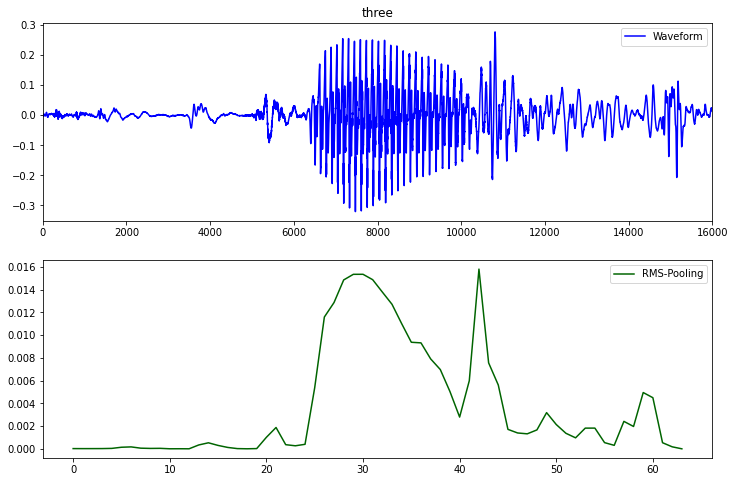

In [ ]:
def plot_rms(rms, ax, color = 'darkgreen'):
  rms_signal = get_rms(rms,250)
  ax.plot(rms_signal,color)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy(),'blue')
axes[0].set_title(label)
axes[0].legend(['Waveform'])
axes[0].set_xlim([0, 16000])

plot_rms(rms_signal.numpy(), axes[1],'darkgreen')
axes[1].legend(['RMS-Pooling'])
plt.show()

In [ ]:
# Now transform the waveform dataset to have rms plots and their corresponding labels as integer IDs.
def get_rms_and_label_id(audio, label):

  # Find rms values using 250 length of window 
  rms_signal = apply_rms(audio,250)
  # shape : (15751,)
  
  rms_signal = tf.expand_dims(rms_signal,-1)
  # shape : (15751,1)
  
  label_id = tf.argmax(label == commands)
  return rms_signal, label_id

In [ ]:
rms_ds = waveform_ds.map(get_rms_and_label_id, num_parallel_calls=AUTOTUNE)

In [ ]:
# Example 
for rms_wav ,label in rms_ds.take(1):
  print("rms_wav is", rms_wav)
  print(" ")
  print("label is: ", label)

rms_wav is tf.Tensor(
[[2.8417259e-07]
 [2.8414652e-07]
 [2.8383360e-07]
 ...
 [1.6827677e-05]
 [1.6827675e-05]
 [1.6839953e-05]], shape=(15751, 1), dtype=float32)
 
label is:  tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
'''
for rms,label_id in rms_ds.take(1):
  x = tf.reshape(rms, [1,15751,1])
  max_pool_1d = tf.keras.layers.MaxPooling1D(pool_size=250,
   strides=250, padding='same')
  y = max_pool_1d(x)
  z = tf.reshape(y,[64])
  print(z)
'''

"\nfor rms,label_id in rms_ds.take(1):\n  x = tf.reshape(rms, [1,15751,1])\n  max_pool_1d = tf.keras.layers.MaxPooling1D(pool_size=250,\n   strides=250, padding='same')\n  y = max_pool_1d(x)\n  z = tf.reshape(y,[64])\n  print(z)\n"

#### ZCR values

In [ ]:
def apply_zcr (waveform, window_size, overLap = 0):

  #ex: waveform = tf.Tensor(
  #[0.0000000e+00 3.0517578e-05 3.0517578e-05 ... 6.1035156e-05 6.1035156e-05
  #6.1035156e-05], shape=(16000,), dtype=float32)

  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  
  # ex: equal_length = tf.Tensor(
  # [0.0000000e+00 3.0517578e-05 3.0517578e-05 ... 6.1035156e-05 6.1035156e-05
  # 6.1035156e-05], shape=(16000,), dtype=float32)

 
  wlen = 16000
  print("wlen", wlen)
  step = window_size - overLap
  print("Step", step)

  #Calcuate how many frames we have
  frameNum = math.ceil(wlen/step)
  print("frameNum", frameNum)
  zcr = []

  for i in range(0,frameNum):
    #print("frameNum ", i, i*step, min(i*step+window_size,wlen))
    curFrame = equal_length[i*step:i*step+min(i*step+window_size,wlen)]
    
    #curFrame = tf.slice(equal_length,begin=[i*step],size = [min(i*step+window_size,wlen)])
    curFrame = curFrame - tf.reduce_mean(curFrame)

    difference = tf.math.multiply(curFrame[0:-1], curFrame[1::]) <= 0 
    count_true = [tf.reduce_sum(tf.cast(difference, tf.float32))]
    zcr = tf.concat([zcr,count_true],-1)
    
  return zcr

In [ ]:
'''
t1 = tf.constant([True,False,True])
print(tf.slice(t1, begin=[0], size=[3]))

t1 = tf.reduce_sum(tf.cast(t1, tf.float32))
print(t1)

t1 = []
for i in range(10):
  t2 = [2]
  t1 = tf.concat([t1,t2],-1)

print(t1)
'''

'\nt1 = tf.constant([True,False,True])\nprint(tf.slice(t1, begin=[0], size=[3]))\n\nt1 = tf.reduce_sum(tf.cast(t1, tf.float32))\nprint(t1)\n\nt1 = []\nfor i in range(10):\n  t2 = [2]\n  t1 = tf.concat([t1,t2],-1)\n\nprint(t1)\n'

In [ ]:
# Extract the first signal of dataset 
for waveform, label in waveform_ds.take(7):
  label = label.numpy().decode('utf-8')
  zcr_signal = apply_zcr(waveform,80)
  print(zcr_signal)

wlen 16000
Step 80
frameNum 200
tf.Tensor(
[  30.   58.   81.  104.  126.  143.  161.  184.  211.  218.  230.  245.
  267.  281.  299.  323.  344.  379.  414.  446.  482.  517.  531.  566.
  611.  643.  683.  721.  745.  767.  790.  806.  813.  829.  849.  871.
  897.  914.  933.  941.  964.  981. 1004. 1034. 1056. 1059. 1085. 1106.
 1119. 1133. 1138. 1159. 1181. 1205. 1222. 1245. 1266. 1271. 1276. 1284.
 1283. 1283. 1293. 1295. 1309. 1313. 1319. 1324. 1330. 1337. 1345. 1348.
 1352. 1360. 1375. 1382. 1389. 1395. 1409. 1416. 1415. 1425. 1435. 1445.
 1448. 1457. 1468. 1473. 1480. 1489. 1494. 1497. 1518. 1485. 1454.  127.
  140. 1012.  204. 1403.  570.  570.  566.  554.  554.  552.  546.  532.
  524.  518.  516.  506.  496.  496.  496.  490.  486.  482.  482.  470.
  462.  462.  462.  454.  450.  448.  444.  438.  436.  430.  430.  226.
  226.  226.  226.  226.  226.  226.  226.  226.  226.  226.  212.  198.
  188.  182.  169.  155.  144.  116.  116.  116.  116.  116.  116.  116.
  116.  

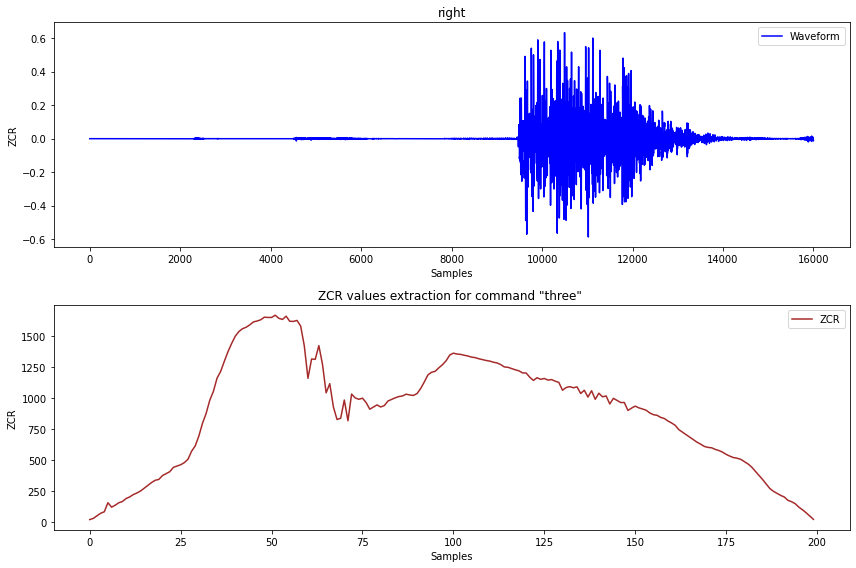

In [ ]:
#Print signal 
fig, axs = plt.subplots(2,figsize=(12,8))
#fig.suptitle("Εxtract RMS values for "+ label+" command",fontsize=20)
axs[0].plot(waveform,'blue')
axs[0].legend(['Waveform'])
axs[0].set_title(label)
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('ZCR')

axs[1].plot(zcr_signal,'brown')
axs[1].legend(['ZCR'])
axs[1].set_title('ZCR values extraction for command "three" ')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('ZCR')

fig.tight_layout()

In [ ]:
# Above as function
def plot_zcr(zcr, ax, color = 'brown'):
  zcr_signal =  tf.convert_to_tensor(zcr,dtype=tf.float32)
  ax.plot(zcr_signal,color)



In [ ]:
# Now transform the waveform dataset to have rms plots and their corresponding labels as integer IDs.
def get_zcr_and_label_id(audio, label):

  # Find rms values using 250 length of window 
  zcr_signal = apply_zcr(audio,80)
  # shape : (15751,)
  
  zcr_signal  = tf.expand_dims(zcr_signal ,-1)
  # shape : (15751,1)
  
  label_id = tf.argmax(label == commands)
  return zcr_signal , label_id

In [ ]:
zcr_ds = waveform_ds.map(get_zcr_and_label_id, num_parallel_calls=AUTOTUNE)

wlen 16000
Step 80
frameNum 200


In [ ]:
# Example 

'''
for zcr_wav ,label in zcr_ds.take(1):
  print("zcr_wav is", zcr_wav)
  print(" ")
  print("label is: ", label)

'''

'\nfor zcr_wav ,label in zcr_ds.take(1):\n  print("zcr_wav is", zcr_wav)\n  print(" ")\n  print("label is: ", label)\n\n'

### Final Results


#### RMS values

In [ ]:
def pool_rms_values (rms_signal, label):

  # Reshape in order to apply AveragePooling1D
  x = tf.reshape(rms_signal, [1,15751, 1])
  
  max_pool_1d = tf.keras.layers.AveragePooling1D(pool_size=250,
   strides=250, padding='same')
  
  y = max_pool_1d(x)

  # Return to proper size 
  pool_rms_signal = tf.reshape(y, [64])
  
  return pool_rms_signal, label

In [ ]:
pool_rms_ds = rms_ds.map(pool_rms_values)

In [ ]:
labels = []
pool_rms_signals = []

for pool_rms_signal, label in pool_rms_ds.take(EXAMPLES):
  
  labels.append(label)
  pool_rms_signals.append(rms_signal)

In [ ]:
#Example 1 
for i in range(len(pool_rms_signals)):

  print('Label:', commands[labels[i].numpy()])

  print('             Pooling RMS                         ')
  display.display(display.Audio(pool_rms_signals[i], rate=16000))
  print(' ')
  print(' ')

Label: go
             Pooling RMS                         


 
 
Label: two
             Pooling RMS                         


 
 
Label: go
             Pooling RMS                         


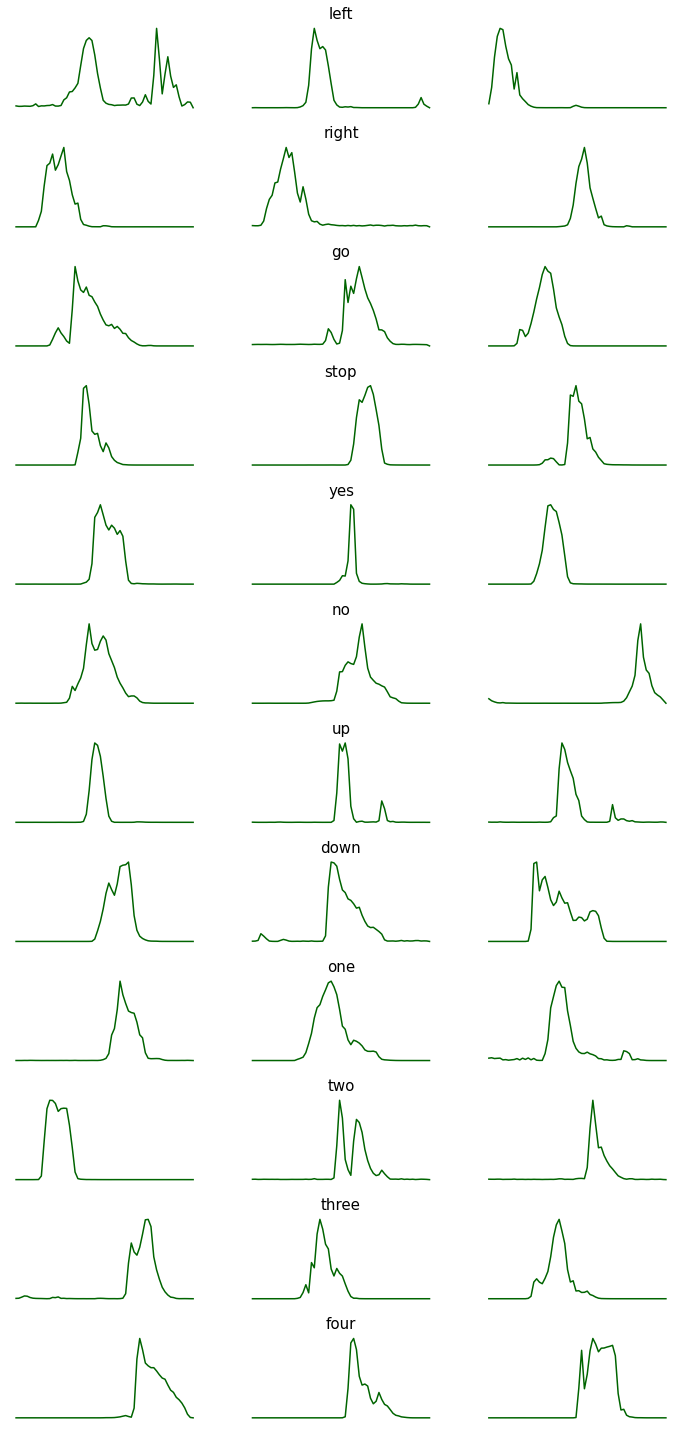

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

<Figure size 216x288 with 0 Axes>

In [ ]:
from google.colab import files 
seen_labels = np.zeros(total_commands,dtype = int)

rows = total_commands
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 20))

# rearange the axes for no overlap
fig.tight_layout()


# Search in 100 samples 
for (rms, label_id) in rms_ds.take(100):
  id = label_id.numpy()
  if (seen_labels[id] <= 2):
    ax = axes[id][seen_labels[id]]
    seen_labels[id] = seen_labels[id] + 1 
    plot_rms(np.squeeze(rms.numpy()), ax)
    if (seen_labels[id] == 2 ):
      ax.set_title(commands[label_id.numpy()],fontsize=15)
    ax.axis('off')


fig1 = plt.gcf()
plt.show()
plt.draw()
plt.figure(figsize=(3,4))
fig1.savefig('time.png',facecolor='white', transparent=False)
files.download("time.png") 

#plt.show()

#### ZCR values

**Be carefull !! Run either Supervised Learning or Unsupervised!**

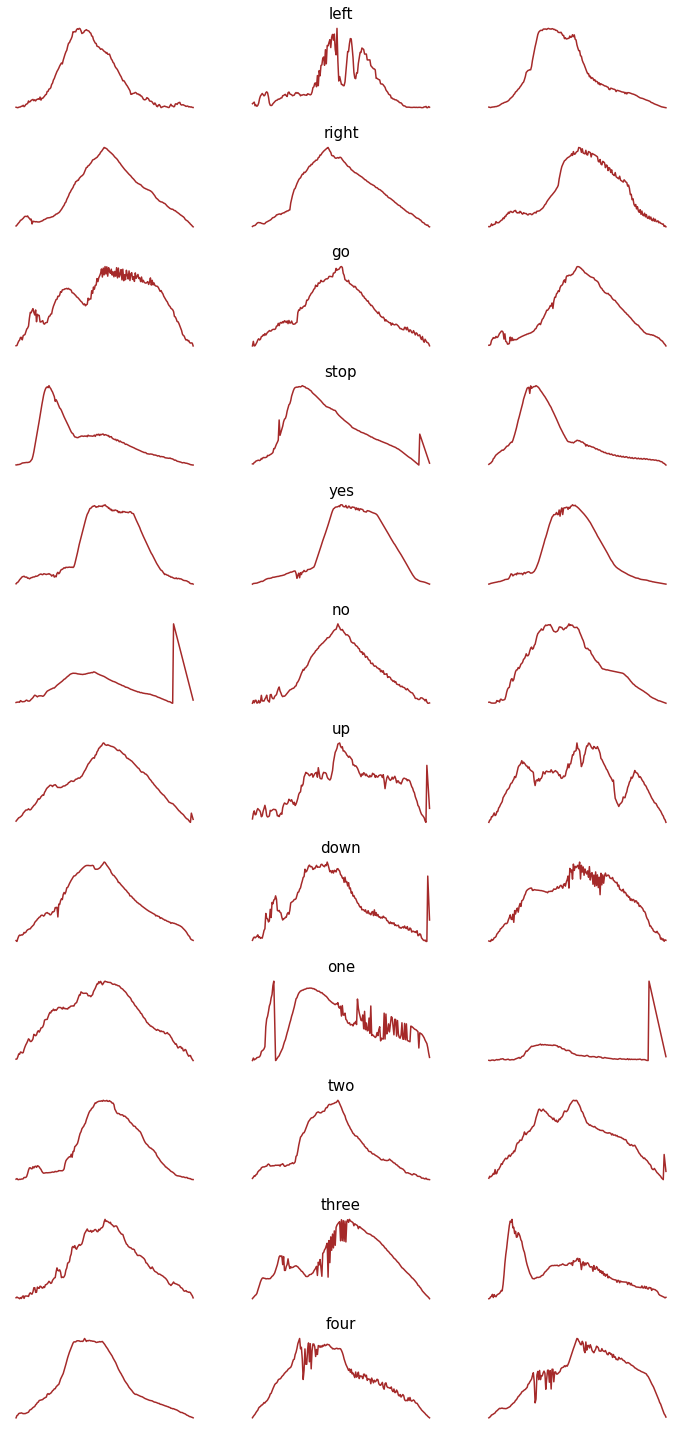

In [ ]:
seen_labels = np.zeros(total_commands,dtype = int)

rows = total_commands
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 20))

# rearange the axes for no overlap
fig.tight_layout()


# Search in 100 samples 
for (zcr, label_id) in zcr_ds.take(100):
  id = label_id.numpy()
  if (seen_labels[id] <= 2):
    ax = axes[id][seen_labels[id]]
    seen_labels[id] = seen_labels[id] + 1 
    plot_zcr(np.squeeze(zcr.numpy()), ax)
    if (seen_labels[id] == 2 ):
      ax.set_title(commands[label_id.numpy()],fontsize=15)
    ax.axis('off')

## Train Models

### Unsupervised Learning

In [ ]:
# We save to .txt files, signals and labels_id
# train_ds changes over time (due to suffling !)


# UNSPUPERVISED 

'''
# FULL DATASET IS NEEDED FOR UNSUPERVISED!
train_ds = pool_rms_ds

mySeries = []
mySeriesLabels = []
for pool_rms_siganl, label_id in train_ds:
  mySeries.append(pool_rms_siganl.numpy())
  mySeriesLabels.append(label_id)

np.savetxt('test2.txt', mySeries)
'''




"\n# FULL DATASET IS NEEDED FOR UNSUPERVISED!\ntrain_ds = pool_rms_ds\n\nmySeries = []\nmySeriesLabels = []\nfor pool_rms_siganl, label_id in train_ds:\n  mySeries.append(pool_rms_siganl.numpy())\n  mySeriesLabels.append(label_id)\n\nnp.savetxt('test2.txt', mySeries)\n"

In [ ]:
mySeries = np.loadtxt('/content/drive/MyDrive/my_project/saved_arrays/unsupervised/saved_signals.txt')
mySeriesLabels =  np.loadtxt('/content/drive/MyDrive/Thesis_George_Giannios/saved_arrays/unsupervised/saved_labels.txt',dtype = int)

In [ ]:
print(mySeries[0])
print(mySeriesLabels[0])

[3.23476627e-07 3.35928945e-07 3.53288414e-07 4.69042476e-07
 1.67542012e-07 9.97797656e-07 1.15229000e-06 3.29432282e-07
 4.24307387e-07 1.21408380e-06 2.59936974e-06 2.15841328e-06
 1.24771009e-06 7.33361048e-07 6.58546355e-07 4.64219852e-07
 5.63415199e-07 5.08036294e-07 3.94323706e-07 3.62762052e-07
 3.05144283e-07 4.90133004e-07 3.82528782e-07 1.36070781e-07
 2.40445047e-07 2.99774086e-07 3.74009517e-07 8.07125730e-07
 4.12988925e-07 3.37461614e-07 8.23929611e-07 2.80574523e-06
 1.05278968e-05 3.11011463e-05 1.13993134e-04 5.43241476e-05
 4.51836640e-05 8.28011689e-05 1.24879254e-04 1.26086685e-04
 1.61563454e-04 1.36466857e-04 1.00660713e-04 8.08202531e-05
 8.39047789e-05 9.10957897e-05 8.35462852e-05 7.80086484e-05
 7.46113292e-05 6.32768133e-05 3.79874327e-05 1.82064232e-05
 9.32447620e-06 5.74023716e-06 1.92167090e-06 7.93284130e-07
 7.48087587e-07 5.52861650e-07 2.25193787e-07 3.43510465e-07
 3.73638500e-07 1.93968063e-07 1.72769461e-07 3.14605558e-07]
10


In [ ]:
# Check if all series have the same length
series_lengths = {len(series) for series in mySeries}
print(series_lengths)


{64}


#### k-means


In [ ]:
#11:13 - 11 : 54 
km = TimeSeriesKMeans(n_clusters=12, metric="dtw")


# mySeries: list of 23 arrays. Each array is composed of 333 elements
labels = km.fit_predict(mySeries)

# labels: [0 3 0 0 0 0 0 0 1 0 0 3 0 1 0 0 3 2 3 0 0 4 0]

In [ ]:
from collections import Counter
print(set(labels))

Counter(labels).keys() # equals to list(set(words))
Counter(labels).values() # counts the elements' frequency


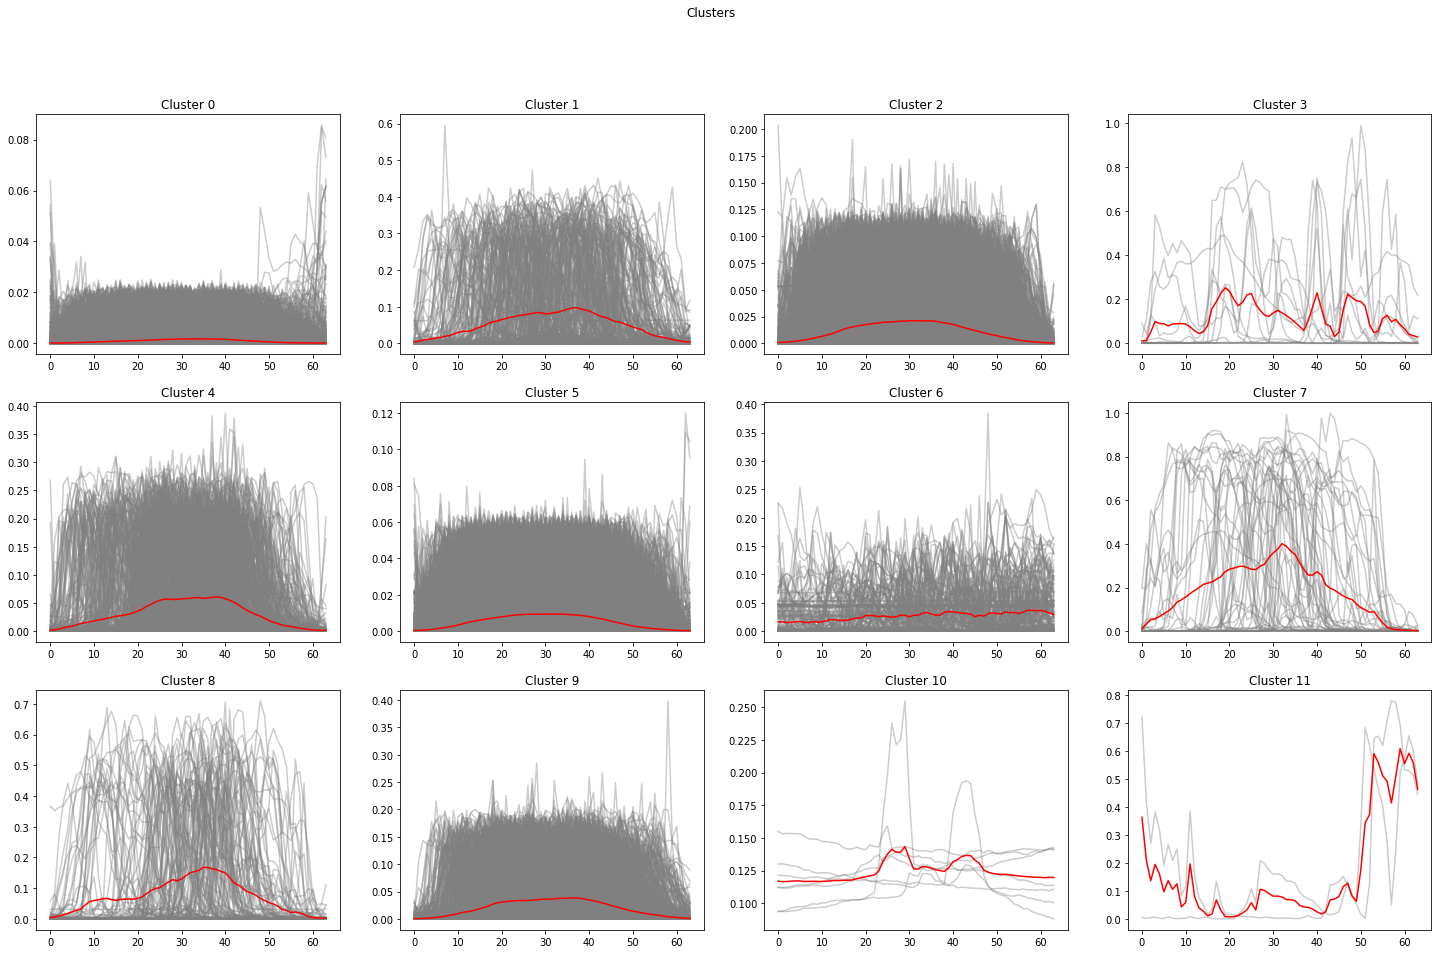

In [ ]:
plot_count = 4

fig, axs = plt.subplots(3,4,figsize=(25,15))
fig.suptitle('Clusters')

row_i=0
column_j=0

# For each label there is,
# plots every series with that label

# set(labels) --> {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
# Takes "0" label first, 
for label in set(labels):
    #Empty cluster
    cluster = []
    for i in range(len(labels)):
            # searching all (23) labels
            if(labels[i]==label):
                # if this refers to "0" label --> gray to proper position 
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    # with red we plot AVERAGE (every time)! 
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*4+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()


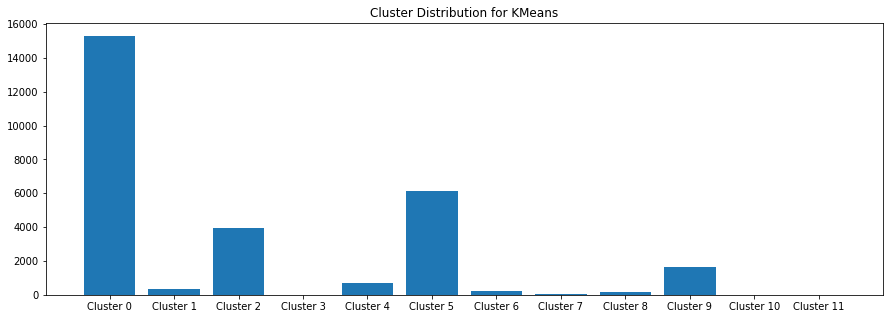

In [ ]:
cluster_count =12 
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

#### K-means (PCA)

In [ ]:
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(mySeries)

In [ ]:
print(mySeries_transformed.shape)

(28462, 2)


In [ ]:

kmeans = KMeans(n_clusters=12,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

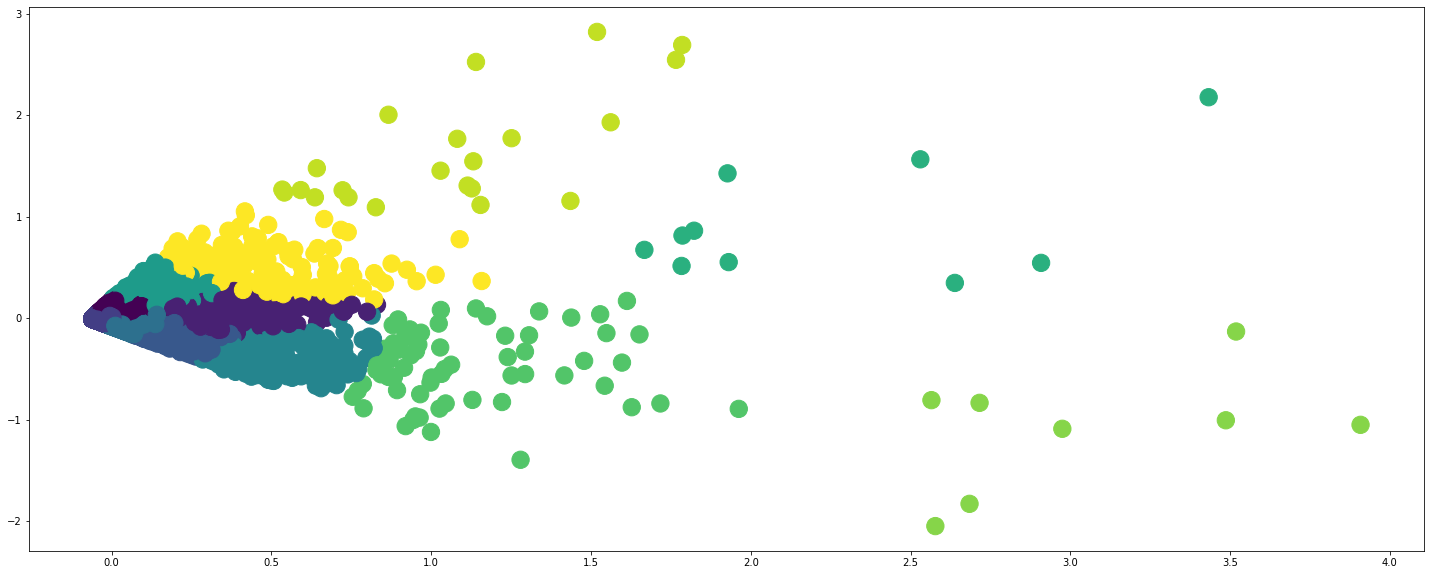

In [ ]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()

In [ ]:
Counter(labels).keys() # equals to list(set(words))
Counter(labels).values() # counts the elements' frequency

dict_values([19270, 3064, 808, 925, 3470, 22, 433, 163, 223, 66, 8, 10])

In [ ]:
plot_count = 4

fig, axs = plt.subplots(3,4,figsize=(25,15))
fig.suptitle('Clusters')

row_i=0
column_j=0

# For each label there is,
# plots every series with that label

# set(labels) --> {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
# Takes "0" label first, 
for label in set(labels):
    #Empty cluster
    cluster = []
    for i in range(len(labels)):
            # searching all (23) labels
            if(labels[i]==label):
                # if this refers to "0" label --> gray to proper position 
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    # with red we plot AVERAGE (every time)! 
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*4+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

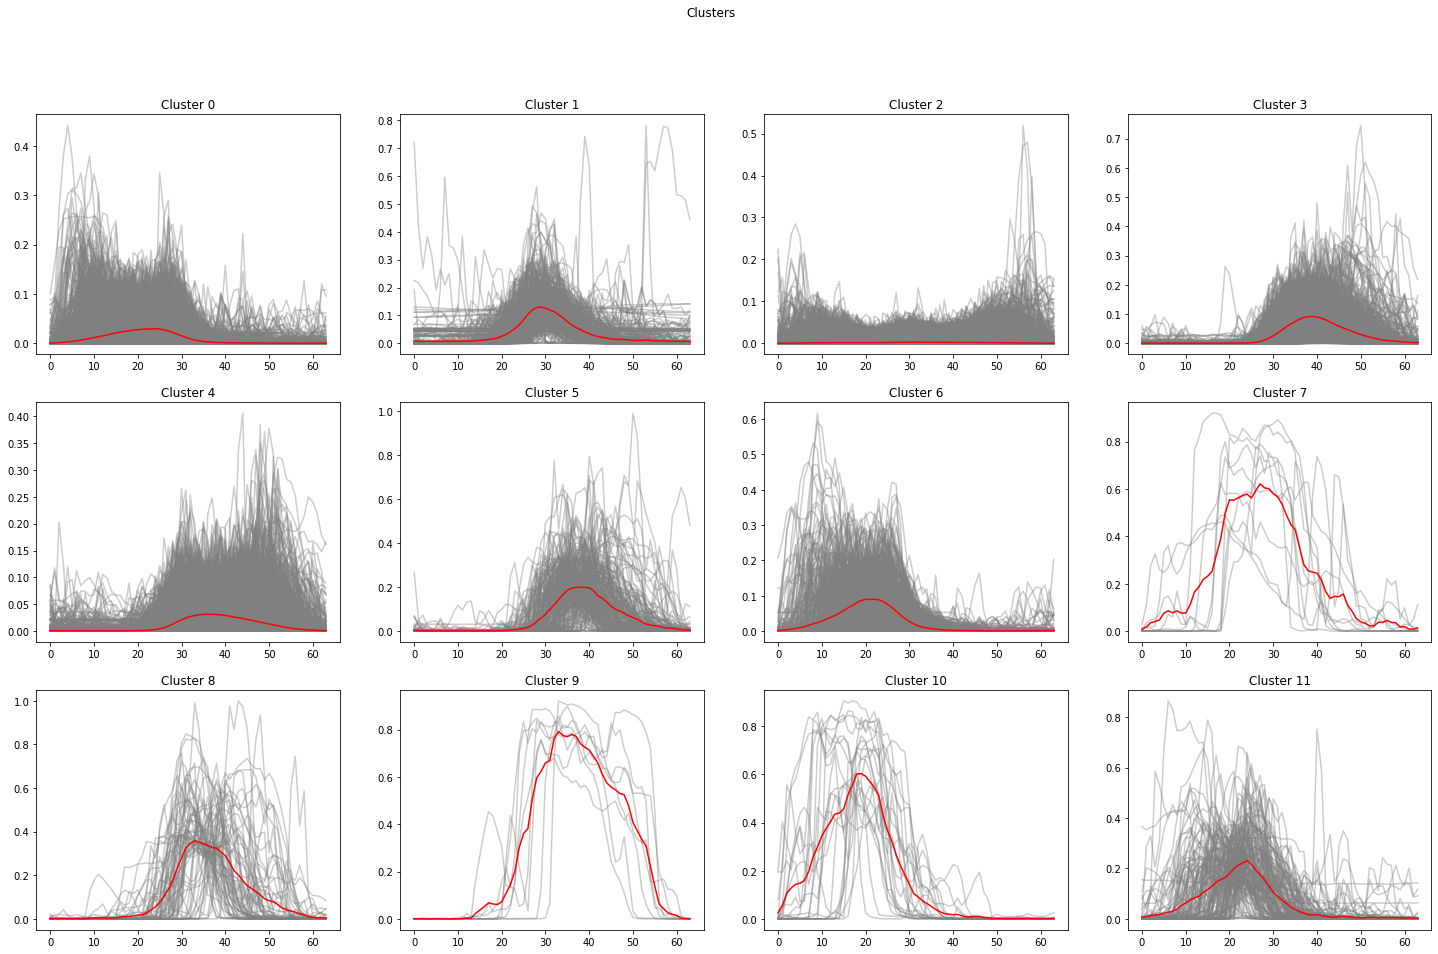

In [ ]:
fig, axs = plt.subplots(3,4,figsize=(25,15))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*4+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

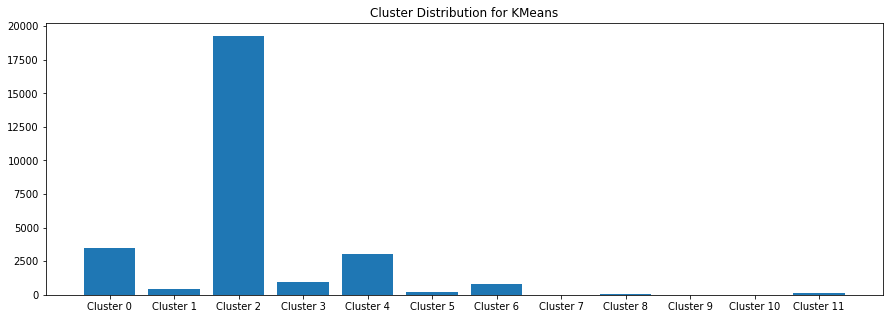

In [ ]:
cluster_count =12 
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

### Supervised Learning

#### Data preprocessing

In [ ]:
FEAT = "rms" # /"mfcc" / "spectrogram" / "rms"

In [ ]:
## Repeat the training set preprocessing on the validation and test sets.
def preprocess_dataset(files,FEAT = "rms"):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_rms_and_label_id,  num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(pool_rms_values,num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = pool_rms_ds
val_ds = preprocess_dataset(val_files,FEAT)
test_ds = preprocess_dataset(test_files,FEAT)

In [ ]:
# Be carefull, for unsupervised learning train_ds should have 28.462 files
print(len(train_ds))

22770


In [ ]:
path = '/content/drive/MyDrive/Thesis_George_Giannios/saved_arrays/supervised/'

# 1:30 hours for all 


# We save to .txt files, signals and labels_id
# train_ds changes over time (due to suffling !)

'''

def save_to_txt (dataset, name):
  mySeries = []
  mySeriesLabels = []
  for pool_rms_siganl, label_id in dataset:
    mySeries.append(pool_rms_siganl.numpy())
    mySeriesLabels.append(label_id)
  
  np.savetxt(path + name, mySeries)
  np.savetxt(path + name +'_labels', mySeriesLabels)



save_to_txt(train_ds,'train')
save_to_txt(val_ds,'val')
save_to_txt(test_ds,'test')

'''

"\n\ndef save_to_txt (dataset, name):\n  mySeries = []\n  mySeriesLabels = []\n  for pool_rms_siganl, label_id in dataset:\n    mySeries.append(pool_rms_siganl.numpy())\n    mySeriesLabels.append(label_id)\n  \n  np.savetxt(path + name, mySeries)\n  np.savetxt(path + name +'_labels', mySeriesLabels)\n\n\n\nsave_to_txt(train_ds,'train')\nsave_to_txt(val_ds,'val')\nsave_to_txt(test_ds,'test')\n\n"

In [ ]:
X_train = np.loadtxt('/content/drive/MyDrive/Thesis_George_Giannios/saved_arrays/supervised/train')
X_val= np.loadtxt('/content/drive/MyDrive/Thesis_George_Giannios/saved_arrays/supervised/val')
X_test = np.loadtxt('/content/drive/MyDrive/Thesis_George_Giannios/saved_arrays/supervised/test')

y_train = np.loadtxt('/content/drive/MyDrive/Thesis_George_Giannios/saved_arrays/supervised/train_labels')
y_val = np.loadtxt('/content/drive/MyDrive/Thesis_George_Giannios/saved_arrays/supervised/val_labels')
y_test = np.loadtxt('/content/drive/MyDrive/Thesis_George_Giannios/saved_arrays/supervised/test_labels')


y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)


#All these are saved as arrays not dataframes

In [ ]:
# Concathenate validation and test 
X_test = np.concatenate((X_val,X_test))
y_test = np.concatenate((y_val,y_test))

In [ ]:
X_train

array([[6.49789854e-06, 4.33723872e-05, 1.31825320e-04, ...,
        1.21652519e-07, 6.83624606e-08, 5.38685576e-08],
       [7.93427368e-09, 9.73474013e-09, 1.10844205e-08, ...,
        8.83304896e-09, 4.90930407e-09, 7.06720238e-09],
       [1.49281241e-05, 1.61133557e-05, 1.57064242e-05, ...,
        1.50544438e-05, 8.54106474e-06, 0.00000000e+00],
       ...,
       [2.69533262e-09, 2.77003531e-09, 2.57891153e-09, ...,
        3.10000536e-09, 3.21975113e-09, 3.17516702e-09],
       [4.98106356e-09, 9.37049016e-09, 9.78020420e-09, ...,
        1.31837190e-08, 2.05172146e-08, 2.82690262e-08],
       [8.40031571e-05, 3.45374610e-05, 2.31076447e-05, ...,
        1.36983488e-03, 6.82626734e-04, 1.74674802e-04]])

#### Classification Algorithms

##### Tabular Form

In [ ]:
# Convert to tabular form !
X_train_tab = pd.DataFrame(X_train)
X_test_tab =  pd.DataFrame(X_test)

In [ ]:
X_train_tab.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,6.497899e-06,4.337239e-05,1.318253e-04,4.569589e-04,1.201949e-03,1.617431e-03,2.176369e-03,2.781586e-03,2.573866e-03,1.507881e-03,7.459874e-04,6.335955e-04,4.968396e-04,2.820232e-04,1.839670e-04,9.762160e-05,6.244445e-05,5.743892e-05,7.056702e-05,1.015720e-04,9.729507e-05,9.463475e-05,1.116251e-04,1.578910e-04,0.000218,0.000098,0.000069,0.000068,0.000093,0.000092,0.000038,0.000034,0.000027,0.000011,0.000004,0.000002,0.000001,6.453245e-07,3.446422e-07,2.882394e-07,2.306949e-07,1.382499e-07,1.444067e-07,1.269996e-07,9.627377e-08,1.431636e-07,1.222121e-07,8.287911e-08,1.039512e-07,8.500399e-08,8.116395e-08,1.164315e-07,1.092528e-07,5.217479e-08,1.201851e-07,1.262035e-07,5.822745e-08,7.168723e-08,9.624795e-08,4.747400e-08,8.032271e-08,1.216525e-07,6.836246e-08,5.386856e-08
1,7.934274e-09,9.734740e-09,1.108442e-08,9.157691e-09,5.292131e-09,6.094957e-09,9.826153e-09,3.543741e-08,6.588076e-08,8.250456e-08,5.567113e-08,8.564633e-09,6.244147e-09,3.759531e-09,5.034918e-09,8.271884e-09,1.511708e-05,1.581213e-04,4.788022e-04,7.045581e-04,1.825053e-03,5.835380e-03,7.506161e-03,8.585254e-03,0.007780,0.008552,0.008029,0.003373,0.001009,0.000570,0.000714,0.000544,0.000545,0.000732,0.000497,0.000518,0.000510,4.137781e-04,4.043017e-04,3.293410e-04,2.385633e-04,1.084958e-04,6.248349e-05,4.234879e-05,2.375994e-05,1.512770e-05,9.138667e-06,4.444625e-06,5.084160e-06,8.266217e-07,3.547691e-07,9.071653e-08,3.167705e-08,2.922197e-08,1.420271e-08,4.285976e-09,2.634819e-09,3.236006e-09,6.146158e-09,2.235224e-08,1.574205e-08,8.833049e-09,4.909304e-09,7.067202e-09
2,1.492812e-05,1.611336e-05,1.570642e-05,1.456847e-05,1.565958e-05,1.531967e-05,1.614827e-05,1.574586e-05,1.651694e-05,1.614947e-05,1.532620e-05,1.584321e-05,1.627056e-05,1.554221e-05,1.492586e-05,1.775416e-05,1.531981e-05,1.631434e-05,1.759555e-05,1.559206e-05,1.624452e-05,1.918231e-05,2.521135e-04,1.177295e-03,0.000822,0.000451,0.000152,0.000400,0.002715,0.004535,0.005764,0.006488,0.007112,0.007511,0.007473,0.007098,0.005631,4.524808e-03,3.594743e-03,2.875409e-03,2.301887e-03,1.792845e-03,1.438005e-03,1.131837e-03,8.235705e-04,6.569303e-04,2.364126e-04,3.113919e-05,1.656094e-05,1.434819e-05,1.386519e-05,1.509612e-05,1.547243e-05,1.654488e-05,1.540586e-05,1.546313e-05,1.444523e-05,1.598636e-05,1.499640e-05,1.815113e-05,1.679546e-05,1.505444e-05,8.541065e-06,0.000000e+00
3,9.286889e-08,9.930477e-08,1.878045e-07,1.657239e-07,1.293895e-07,1.025697e-07,1.193179e-07,1.154686e-07,9.955085e-08,9.356839e-08,9.736141e-08,1.014616e-07,7.628047e-08,1.002780e-07,1.273723e-07,1.060962e-07,1.014277e-07,1.130158e-07,1.123461e-07,1.078307e-07,1.092872e-07,1.157072e-07,1.338386e-07,3.240381e-07,0.000087,0.000324,0.000768,0.001263,0.002447,0.003052,0.005048,0.006447,0.006813,0.006978,0.006394,0.005923,0.003630,1.230894e-03,1.765127e-04,1.229757e-04,8.337924e-05,2.989896e-05,1.825704e-05,1.034942e-05,6.530552e-06,3.306895e-06,5.455418e-06,2.340429e-05,4.646742e-06,1.740505e-06,1.003977e-06,6.737882e-07,5.822932e-07,6.050319e-07,4.211724e-07,4.357559e-07,3.933621e-07,4.101090e-07,4.046910e-07,4.159542e-07,3.875390e-07,4.303117e-07,3.904010e-07,3.248022e-07
4,2.749190e-06,6.693816e-06,3.499403e-06,2.589140e-06,4.393993e-06,3.877703e-06,1.237572e-05,4.117435e-05,2.800974e-05,7.294190e-06,1.458963e-05,3.463550e-05,9.076162e-06,5.516702e-06,3.257461e-06,5.951143e-06,4.605857e-06,4.068105e-05,3.746274e-05,6.543767e-06,1.176765e-05,1.449517e-05,3.071197e-04,1.859949e-03,0.004981,0.007631,0.009561,0.011312,0.013744,0.035131,0.046989,0.044807,0.040448,0.041497,0.034156,0.028896,0.023310,1.658945e-02,1.362440e-02,9.747675e-03,7.290660e-03,8.116862e-03,3.013117e-03,1.553856e-03,7.051618e-04,4.990841e-04,8.879163e-04,6.428253e-04,8.095441e-04,1.806457e-04,3.067509e-05,7.025902e-05,1.020490e-04,8.873836e-04,4.113433e-04,6.021864e-05,2.114674e-0

###### Dummy Classifier

In [ ]:
# Baseline Classifier for Comparison
from sklearn.dummy import DummyClassifier

classifier = DummyClassifier(strategy="prior")
classifier.fit(X_train_tab, y_train)
classifier.score(X_test_tab, y_test)

0.07940969782150387

###### Random Forest

##### Nested Form

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=2500)
classifier.fit(X_train_tab, y_train)
y_pred = classifier.predict(X_test_tab)
accuracy_score(y_test, y_pred)


#fast 
# (n_est =1000 -->) 7 min 
# 2000:10 min 
# 2500: 12 min

0.4007378777231202

We treat each observation as a separate feature and thus ignore they are ordered in time. A tabular algorithm cannot make use of the fact that features are ordered in time, i.e. if we changed the order of the features, the fitted model and predictions wouldn't change

Instead of working in the domain of the time series, we extract features from time series and choose to work in the domain of the features. Again, sometimes this works well, sometimes it doesn't. The main difficulty is finding discriminative features for the classification problem

In [ ]:
# From tabular to nested representation 
X_train = from_2d_array_to_nested(X_train_tab)
X_test = from_2d_array_to_nested(X_test_tab)

In [ ]:
X_train.head()

,0
0,0 6.497899e-06 1 4.337239e-05 2 1....
1,0 7.934274e-09 1 9.734740e-09 2 1....
2,0 0.000015 1 0.000016 2 0.000016 3...
3,0 9.286889e-08 1 9.930477e-08 2 1....
4,0 0.000003 1 0.000007 2 0.000003 3...


###### Time Series Tree

Time series forest is a modification of the random forest algorithm to the time series setting:

1. Split the series into multiple random intervals,
2. Extract features (mean, standard deviation and slope) from each interval,
3. Train a decision tree on the extracted features,
4. Ensemble steps 1 - 3.


In [ ]:
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.utils.slope_and_trend import _slope
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

steps = [
    (
        "extract",
        RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        ),
    ),
    ("clf", DecisionTreeClassifier()),
]
time_series_tree = Pipeline(steps)

In [ ]:
time_series_tree.fit(X_train, y_train)
time_series_tree.score(X_test, y_test)

0.18060435699226984

###### Time Series Forest (Interval Based)

In [ ]:
tsf = ComposableTimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100,
    criterion="entropy",
    bootstrap=True,
    oob_score=True,
    random_state=1,
    n_jobs=-1,
)

In [ ]:
tsf.fit(X_train, y_train)

if tsf.oob_score:
    print(tsf.oob_score_)

0.29068950373298197


In [ ]:
# 7 min
tsf = ComposableTimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.3188685874912157

###### Random Forest on RISE (Frequency Based)

Another popular variant of time series forest is the so-called Random Interval Spectral Ensemble (RISE), which makes use of several series-to-series feature extraction transformers, including:

* Fitted auto-regressive coefficients,
* Estimated autocorrelation coefficients,
* Power spectrum coefficients.

In [ ]:
#2 min 
from sktime.classification.interval_based import RandomIntervalSpectralForest

rise = RandomIntervalSpectralForest(n_estimators=10)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.22680955727336613

In [ ]:
#10 min 
from sktime.classification.interval_based import RandomIntervalSpectralForest

rise = RandomIntervalSpectralForest(n_estimators=20)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.26774420238931834

In [ ]:
#20 min 
from sktime.classification.interval_based import RandomIntervalSpectralForest

rise = RandomIntervalSpectralForest(n_estimators=50)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.3053408292340126

In [ ]:
#40 min 
from sktime.classification.interval_based import RandomIntervalSpectralForest

rise = RandomIntervalSpectralForest(n_estimators=100)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.3186929023190443

In [ ]:
#67 min
from sktime.classification.interval_based import RandomIntervalSpectralForest

rise = RandomIntervalSpectralForest(n_estimators=150)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.33959943780744906

In [ ]:
#90 min
from sktime.classification.interval_based import RandomIntervalSpectralForest

rise = RandomIntervalSpectralForest(n_estimators=200)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.3466268446943078

In [ ]:
#4h
from sktime.classification.interval_based import RandomIntervalSpectralForest

rise = RandomIntervalSpectralForest(n_estimators=500)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.3524244553759663

In [ ]:
a = X_train[:1000]

In [ ]:
b = y_train[:1000]

In [ ]:
c = X_test[:1000]

In [ ]:
d = y_test[:1000]

###### BOSSEnsemble


In [ ]:
# Samples | Time
# ----------------
# 100     | 12 sec
# 1000    | 15 min  20 %
# 5000    | 6 hours 25 %

from sktime.classification.dictionary_based import BOSSEnsemble


tsf = BOSSEnsemble()
tsf.fit(a, b)
tsf.score(c, d)

0.251

In [ ]:
# Samples | Time
# ----------------
# 100     | 2 sec
# 1000    | 15 min  20 %
# 5000    | 6 hours 11.4 %

from sktime.classification.distance_based import ShapeDTW

tsf = ShapeDTW()
tsf.fit(a, b)
tsf.score(c, d)


0.114

##### KNeighbors (Distance Based)

In [ ]:
# 1 hour!
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=5, distance="dtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.20660576247364723

In [ ]:
# 1 hour!
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=15, distance="dtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.22294448348559381

In [ ]:
# 1 hour!
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=30, distance="dtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)
#3:42

0.22505270555165144

In [ ]:
# 1 hour!
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=50, distance="dtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.22540407589599437

In [ ]:
# 1 hour!
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=100, distance="dtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.2326071679550246

#### Neural Network 


In [ ]:
for rms, _ in pool_rms_ds.take(1):
  input_shape = rms.shape
 
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (64,)


In [ ]:
## This cell should run only if you work with tensorflow!

## Batch the training and validation sets for model training.

batch_size = 4

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


## Reduce read latency while training the model.
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
# Create iterator for train_ds 

# dataset_iterator= iter(train_ds)
# print(next(dataset_iterator)) 
# print(next(dataset_iterator)) 

In [ ]:
# Taking the 1st batch of train_ds 
features, labels = next(iter(train_ds))

In [ ]:
# Taking the 1st signal of 1st batch 
my_signal = features[0].numpy()
print("Label:",commands[labels.numpy()[0]])

Label: up


Text(0.5, 1.0, 'up')

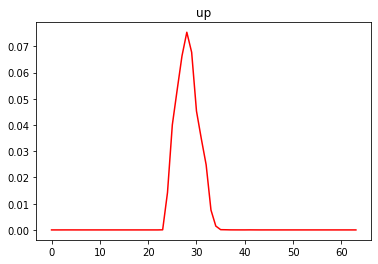

In [ ]:
plt.plot(my_signal,'r')
plt.title(commands[labels[0].numpy()])

##### Define Model

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape =(64,)) , # input shape required
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(num_labels * 4 , activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(num_labels,activation = tf.nn.softmax)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 48)                3120      
_________________________________________________________________
dropout_9 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 12)                588       
Total params: 7,868
Trainable params: 7,868
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# Making predictions for 1s batch 

predictions = model(features)

    ### predictions.shape = (4,12)

# Taking the probabillites of 1st signal (1st batch )

#tf.nn.softmax(predictions[:1])

In [ ]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))


Prediction: [11 11 11 11]
    Labels: [6 2 2 8]


##### Fit Model

In [ ]:
# 1st epoch: 1 h 
EPOCHS = 50
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
5693/5693 [==============================] - 10s 2ms/step - loss: 2.4836 - accuracy: 0.0888 - val_loss: 2.4800 - val_accuracy: 0.0956
Epoch 2/50
5693/5693 [==============================] - 10s 2ms/step - loss: 2.4802 - accuracy: 0.0968 - val_loss: 2.4749 - val_accuracy: 0.1012
Epoch 3/50
5693/5693 [==============================] - 10s 2ms/step - loss: 2.4715 - accuracy: 0.1157 - val_loss: 2.4655 - val_accuracy: 0.1152
Epoch 4/50
5693/5693 [==============================] - 9s 2ms/step - loss: 2.4608 - accuracy: 0.1312 - val_loss: 2.4589 - val_accuracy: 0.1286
Epoch 5/50
5693/5693 [==============================] - 10s 2ms/step - loss: 2.4519 - accuracy: 0.1415 - val_loss: 2.4615 - val_accuracy: 0.1275
Epoch 6/50
5693/5693 [==============================] - 10s 2ms/step - loss: 2.4478 - accuracy: 0.1457 - val_loss: 2.4471 - val_accuracy: 0.1402
Epoch 7/50
5693/5693 [==============================] - 10s 2ms/step - loss: 2.4416 - accuracy: 0.1539 - val_loss: 2.4407 - val_acc

No handles with labels found to put in legend.


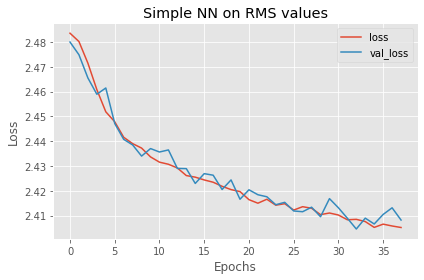

In [ ]:
plt.style.use("ggplot")
metrics = history.history

fig1 = plt.gcf()
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.title("Simple NN on RMS values")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(['loss', 'val_loss'])
plt.show()


fig1.savefig('nn_rms.png')

##### Evaluate Model

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 20%


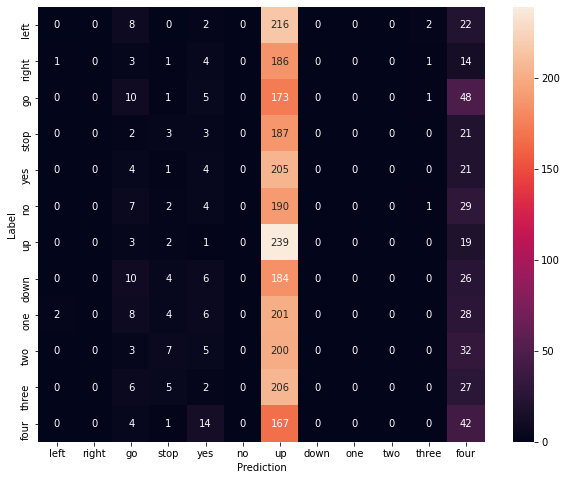

In [ ]:
#confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
#plt.figure(figsize=(10, 8))
#sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
#            annot=True, fmt='g')
#plt.xlabel('Prediction')
#plt.ylabel('Label')
#plt.show()

In [ ]:
! pip install hcrystalball

     |████████████████████████████████| 788kB 5.2MB/s 
     |████████████████████████████████| 194kB 11.2MB/s 
     |████████████████████████████████| 16.9MB 232kB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 378kB 32.1MB/s 
     |████████████████████████████████| 40kB 5.1MB/s 
     |████████████████████████████████| 266kB 40.5MB/s 
  Created wheel for pyCalverter: filename=pyCalverter-1.6.1-cp37-none-any.whl size=4201 sha256=878d58cb5f03b8c0f7d825a0fd4288590464790ba752afb6016b6b3fe2ac14b6
  Stored in directory: /root/.cache/pip/wheels/77/4d/86/db4ff4eca6178dbbd5a365d095f97f6021e2a48f09908be79c
  Created wheel for skyfield: filename=skyfield-1.39-cp37-none-any.whl size=417567 sha256=535a6f60ba3d3f555c0b2b1a7d369c8992feebdadd86d0e11c78f2a6954541dd
  Stored in directory: /root/.cache/pip/wheels/bb/a4/a6/2f7e3bc8ec08ffc7485c92d18dd726e0dbafc0f7a8b1519518
  Created wheel for jplephem: filename=jplephem-2.15-cp37-none-any.whl size=46020 sh

In [ ]:
from sktime.utils import all_estimators

all_estimators(estimator_types="classifier")



[('BOSSEnsemble', sktime.classification.dictionary_based._boss.BOSSEnsemble),
 ('ColumnEnsembleClassifier',
  sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier),
 ('ComposableTimeSeriesForestClassifier',
  sktime.classification.compose._ensemble.ComposableTimeSeriesForestClassifier),
 ('ContractableBOSS',
  sktime.classification.dictionary_based._cboss.ContractableBOSS),
 ('ElasticEnsemble',
  sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble),
 ('HIVECOTEV1', sktime.classification.hybrid._hivecote_v1.HIVECOTEV1),
 ('IndividualBOSS',
  sktime.classification.dictionary_based._boss.IndividualBOSS),
 ('IndividualTDE', sktime.classification.dictionary_based._tde.IndividualTDE),
 ('KNeighborsTimeSeriesClassifier',
  sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier),
 ('MUSE', sktime.classification.dictionary_based._muse.MUSE),
 ('MrSEQLClassifier',
  sktime.classification.shapelet_based.mrseql.mrseql.MrSEQL

### References

[Arrow Head Problem using TimeSeries](https://github.com/alan-turing-institute/sktime/blob/main/examples/02_classification_univariate.ipynb)  


[Introduction to Time Series Clustering](https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering) 
